In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from numpy import pi, e
from numpy.linalg import inv, det
from numpy.linalg import norm as LA_norm
from numpy.random import random
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
from termcolor import colored
import itertools
from itertools import combinations, product

In [2]:
def create_matrix(m, n):
    return np.random.rand(m, n)

def initial_inputs(flag):
    if flag == 0:
        # Create initial encoder inputs (B, Sigma_W)
        B = create_matrix(m, n)
        Sigma_W = make_spd_matrix(m)
        return np.concatenate(([flag], B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        # Create initial decoder inputs (A, Sigma_Z)
        A = create_matrix(n, m)
        Sigma_Z = np.diag(random(n))
        return np.concatenate(([flag], A.reshape((n*m)), Sigma_Z.reshape((n*n))))

def is_close_to_zero(arr, etol):
    return np.allclose(arr, 0, atol=etol)

def is_singular(matrix):
    is_singular = np.linalg.matrix_rank(matrix) < min(matrix.shape)
    if is_singular:
        print(colored('The matrix is singular.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not singular.', 'red', attrs=['bold']))

def is_positive_definite(matrix):
    if np.all(np.linalg.eigvals(matrix) > 0):
        print(colored('The matrix is positive definite.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not positive definite.', 'red', attrs=['bold']))

def matrix_B(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    B = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A) @ A.T @ inv_Sigma_Z_hat
    return B

def covariance_matrix_W(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    Sigma_W = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A)
    return Sigma_W

def matrix_A(B, Sigma_W):
    A = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B) @ B.T @ inv(Sigma_W)
    return A

def covariance_matrix_Z(B, Sigma_W):
    Sigma_Z = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B)
    diagonalized_Sigma_Z = np.diag(Sigma_Z.diagonal())
    return diagonalized_Sigma_Z

def covariance_matrix_XV(B):
    cov_XV = np.block([[np.identity(m), B @ eigenvectors @ Sigma_V],
                       [(B @ eigenvectors @ Sigma_V).T, Sigma_V]])
    return cov_XV

def encoder_mi(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))

def decoder_mi(A, Sigma_Z):
    return 0.5 * np.log(det(A @ A.T + Sigma_Z) / det(Sigma_Z))

def mi_VX(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(sigma_squared * B @ B.T + Sigma_W))

def reconstruction_error(recon, orig):
    norm_diff = LA_norm(orig - recon, 2)
    orig_norm = LA_norm(orig, 2)
    recon_err = norm_diff / orig_norm
    return recon_err

def objective_function(A, B, Sigma_Z, Sigma_W):
    Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
    
    regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
    reconstruction = 0.5 * (np.trace(Sigma_X) + \
                            np.trace(A.T @ inv(Sigma_Z) @ Sigma_Y @ B.T) + \
                            np.trace(inv(Sigma_Z) @ A @ B @ Sigma_Y) - \
                            np.trace(inv(Sigma_Z) @ Sigma_Y) - \
                            np.trace((np.identity(m) + A.T @ inv(Sigma_Z) @ A) @ Sigma_X) - \
                            n * np.log(2 * pi) - np.log(det(Sigma_Z)))
    lambda_term = lamda * np.trace((np.identity(n) - A @ B) @ Sigma_Y @ ((np.identity(n) - A @ B).T) + A @ Sigma_W @ A.T)
    
    return regularizer - gamma * reconstruction + lambda_term

In [3]:
def plot_cost_function(cf_arr):
    """
    Plot values of objective function against iterations t
    """
    plt.plot(range(1, len(cf_arr) + 1), cf_arr)
    plt.xlabel('t')
    plt.ylabel('Cost Function', fontsize=10)
    plt.show()

def plot_encoder_mi(en_mi_arr):
    """
    Plot mutual information of encoder against iterations t
    """
    plt.plot(range(1, len(en_mi_arr) + 1), en_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Encoder', fontsize=10)
    plt.show()

def plot_decoder_mi(de_mi_arr):
    """
    Plot mutual information of decoder against iterations t
    """
    plt.plot(range(1, len(de_mi_arr) + 1), de_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Decoder', fontsize=10)
    plt.show()

In [4]:
def print_optimal_solution(sol, m):
    A_arr = sol[:n*m] 
    B_arr = sol[n*m:2*n*m]
    Sigma_Z_arr = sol[2*n*m:2*n*m+n*n]
    Sigma_Z = Sigma_Z_arr.reshape((n, n))
    Sigma_W_arr = sol[2*n*m+n*n:2*n*m+n*n+m*m]
    Sigma_W = Sigma_W_arr.reshape((m, m))
    cost_function = sol[2*n*m+n*n+m*m:2*n*m+n*n+m*m+1][0]
    en_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0]
    de_mi = sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0]
    recon_err = sol[-1]
    len_cf_mi_arr = sol[2*n*m+n*n+m*m+3:2*n*m+n*n+m*m+6]
    Sigma_X = sol[2*n*m+n*n+m*m+6:2*n*m+n*n+2*m*m+6].reshape((m, m))
    Sigma_Y_hat = sol[2*n*m+n*n+2*m*m+6:2*n*m+2*n*n+2*m*m+6].reshape((n, n))
    
    print(colored('At optimal solution:', attrs=['bold']))
    
    if m > 1:
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nReconstruction error:\n{}'.format(round(recon_err, 8)))
    else:
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))      
        print('\nReconstruction error:\n{}'.format(round(recon_err, 8)))
        
    return len_cf_mi_arr

def print_comprehensive_results(gamma, lamda, flag, m, n, is_arr):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag)[1:1+m*n].reshape((m, n)), initial_inputs(flag)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag)[1:1+n*m].reshape((n, m)), initial_inputs(flag)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print given inputs
    if is_arr == 0:
        if m > 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial matrix B:')
            print(np.round(B.reshape((m, n)), 4))
            print('\nInitial covariance matrix of W:')
            print(np.round(Sigma_W, 4))
        elif m == 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial vector b:')
            print(np.round(B.reshape((m, n)), 4)[0])
            print('\nInitial variance of W:')
            print(np.round(Sigma_W, 4)[0][0])
        elif m > 1 and flag == 1:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial matrix A:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))
        else:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial vector a:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))    
    
        # Print results
        if flag == 0:
            # Compute optimal solution given encoder inputs
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
    
            # Extract length of arrays for cost function and mutual information of encoder and decoder
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            # Plot values of cost function and mutual information against iterations
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)  
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
        
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)
    else:
        if flag == 0:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 8)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 8)
            recon_err = round(opt_sol[-1], 8)
            
            return [recon_err, en_mi, de_mi, opt_sol]
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 8)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 8)
            recon_err = round(opt_sol[-1], 8)
            
            return [recon_err, en_mi, de_mi, opt_sol]

In [5]:
"""

*****************************************************************
**                          ALGORITHM                          **
*****************************************************************
   
Inputs:
- MAX_ITERS: Maximum number of iterations
- n, m: Dimensions of the matrix
- TOL_ERR: Tolerable error
- Sigma_Y: A random nxn positive definite matrix

Algorithm:
1. Initialize flag
    a. If we start with the encoder, set flag = 0.
    b. Otherwise, set flag = 1.
    
2. Generate initial inputs for the iteration step
    a. If flag = 0, then do:
        i. create random initial encoder inputs, including 
            - a random mxn matrix B
            - a random mxm positive definite covariance matrix Sigma_W
        ii. set flag = 1.
    b. If flag = 1, then do:
        i. create random initial decoder inputs, including 
            - a random nxm matrix A
            - a random nxn positive definite covariance matrix Sigma_Z
        ii. set flag = 0.
        
3. Set iteration counter i = 0. 

4. Iterative step
    a. If flag = 0, given the decoder inputs (A, Sigma_Z) at iteration i,
        i. compute the corresponding encoder inputs at iteration i+1:
            B = matrix_B(A, Sigma_Z)
            Sigma_W = covariance_matrix_W(A, Sigma_Z)
        ii. set flag = 1.
        iii. compute the resulting gamma-VAE cost function and mutual information of the encoder.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
    b. If flag = 1, given the encoder inputs (B, Sigma_W) at iteration i,
        i. compute the corresponding decoder inputs at iteration i:
            A = matrix_A(B, Sigma_W)
            Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
        ii. set flag = 0.
        iii. compute the resulting gamma-VAE cost function, mutual information of the decoder, and reconstruction error.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
            
5. Increment iteration counter i <- i + 1.

6. If the iteration counter i < MAX_ITERS, then move back to step 4.
    Otherwise, move to step 7.
    
7. Compute the values of Sigma_X and Sigma_Y_hat.
        
8. Display results
    a. display the optimal solution (A, B, Sigma_Z, Sigma_W).
    b. display the corresponding minimum value of gamma-VAE cost function.
    c. display the resulting mutual information of both encoder and decoder.
    d. display the values of Sigma_X and Sigma_Y_hat.
    e. display the value of reconstruction error.
    f. move to step 9.
    
9. Stop.

"""

def rate_distortion(inputs, is_arr):
    flag = inputs[0]
    if flag == 0:
        B = inputs[1:1+m*n].reshape((m, n))
        Sigma_W = inputs[1+m*n:1+m*n+m*m].reshape((m, m))
        flag = 1
        # Array of current encoder inputs (B_t, Sigma_W_t)
        current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        A = inputs[1:1+n*m].reshape((n, m))
        Sigma_Z = inputs[1+n*m:1+n*m+n*n].reshape((n, n))
        flag = 0
        # Array of current decoder inputs (A_t, Sigma_Z_t)
        current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
    
    # Cost function and mutual information arrays
    cf_arr = []
    en_mi_arr = []
    de_mi_arr = [] 

    # Iteration step
    try:
        for i in range(0, MAX_ITERS):
            if  flag == 0:
                B = matrix_B(A, Sigma_Z)
                Sigma_W = covariance_matrix_W(A, Sigma_Z)
                flag = 1
                
                # Check if the value of the cost function is not a number
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_en_mi = encoder_mi(B, Sigma_W)
                en_mi_arr = np.concatenate((en_mi_arr, [current_en_mi]))
                
                # For the first iteration, update the current encoder inputs and value of the cost function
                if i == 0:
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. B and itself in the previous iteration
                #    ii. Sigma_W and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current encoder inputs and value of the cost function
                else:
                    B_diff = B - current_encoder_inputs[:m*n].reshape((m, n))
                    B_norm_diff = LA_norm(B_diff, 'fro')
                    Sigma_W_diff = Sigma_W - current_encoder_inputs[m*n:m*n+m*m].reshape((m, m))
                    Sigma_W_norm_diff = LA_norm(Sigma_W_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    # Check for convergence
                    if B_norm_diff <= TOL_ERR and Sigma_W_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
            else:
                A = matrix_A(B, Sigma_W)
                Sigma_Z = covariance_matrix_Z(B, Sigma_W)
                flag = 0
                
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_de_mi = decoder_mi(A, Sigma_Z)
                de_mi_arr = np.concatenate((de_mi_arr, [current_de_mi]))
                
                Sigma_Y_hat = A @ A.T + Sigma_Z
                recon_err = reconstruction_error(Sigma_Y_hat, Sigma_Y)
                
                # For the first iteration, update the current decoder inputs and value of the cost function
                if i == 0:
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. A and itself in the previous iteration
                #    ii. Sigma_Z and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current dencoder inputs and value of the cost function                
                else:
                    A_diff = A - current_decoder_inputs[:n*m].reshape((n, m))
                    A_norm_diff = LA_norm(A_diff, 'fro')
                    Sigma_Z_diff = Sigma_Z - current_decoder_inputs[n*m:n*m+n*n].reshape((n, n))
                    Sigma_Z_norm_diff = LA_norm(Sigma_Z_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    # Check for convergence
                    if A_norm_diff <= TOL_ERR and Sigma_Z_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break                       

        # Compute Sigma_X and Sigma_Y_hat  
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi],
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
          
        if is_arr == 0 and i == MAX_ITERS - 1 and recon_err > MAX_RECON_ERR:
            print(colored('\nMax iterations was reached!', 'red', attrs=['bold']))
            print('There is NO solutions that has reconstruction error statisfying the tolerance error = {}.\n'.format(MAX_RECON_ERR))
            
        return sol
    
    except Exception as e:
        if is_arr == 0:
            print(colored('\nThe algorithm fails to converge after {} iterations due to {}.\n'.format(i+1, e), 'red', attrs=['bold']))
         
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi], 
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol

In [6]:
def generate_Sigma_V(case):
    for case_idx in range(num_cases):
        if case_idx == 0:
            # Case 1: Independent of generative parameters
            std_devs = [std_dev_v1, std_dev_v2, std_dev_v3]
            V_1 = [np.random.normal(mean, std_dev, size=num_samples) for std_dev in std_devs]

            # Compute covariance matrix of V 
            Sigma_V_1 = np.round(np.cov(V_1), 4)
        
        elif case_idx == 1:
            # Case 2: Linear dependence of v_1 and v_2, with independence of v_3
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            v_3 = np.random.normal(mean, std_dev_v3, size=num_samples)
            
            # Calculate v_2 using scaling factor alpha and random noise
            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            v_2 = alpha * v_1 + random_noise_z2
            
            # Create generative variable V
            V_2 = np.array([v_1, v_2, v_3])

            # Compute covariance matrix of V 
            Sigma_V_2 = np.round(np.cov(V_2), 4)  
        
        else:
            # Case 3: Linear dependence of v_2 and v_3, with v_1
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            
            # Calculate additional generative parameters using scaling factors
            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            random_noise_z3 = np.random.normal(mean, std_dev_z3, num_samples)
            v_2 = alpha * v_1 + random_noise_z2
            v_3 = beta * v_1 + random_noise_z3

            # Create generative variable V
            V_3 = np.array([v_1, v_2, v_3])

            # Compute covariance matrix of V 
            Sigma_V_3 = np.round(np.cov(V_3), 4)
    
    if case == 0:
        print(colored('Scenario 1:', attrs=['bold','underline']))
        print(f'Given (sigma_v1, sigma_v2, sigma_v3) = {std_dev_v1, std_dev_v2, std_dev_v3}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_1)
        is_singular(Sigma_V_1)
        return Sigma_V_1
    
    elif case == 1:
        print(colored('\nScenario 2:', attrs=['bold','underline']))
        print(f'Given (sigma_v1, sigma_v3) = {std_dev_v1, std_dev_v3}, alpha = {alpha}, and sigma_z2 = {std_dev_z2}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_2)
        is_singular(Sigma_V_2) 
        return Sigma_V_2
    
    else:
        print(colored('\nScenario 3:', attrs=['bold','underline']))
        print(f'Given sigma_v1 = {std_dev_v1}, (alpha, beta) = {alpha, beta}, and (sigma_z2, sigma_z3) = {std_dev_z2, std_dev_z3}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_3)
        is_singular(Sigma_V_3)  
        return Sigma_V_3

## I. Inputs

In [7]:
"""
Given:
1. Maximum number of iterations: MAX_ITERS = 10,000
2. Dimensions of the matrix: s = 3, n = 4, and m = 3
3. Tolerable error: TOL_ERR = 1e-8
4. Reconstruction error tolerance: MAX_RECON_ERR = 0.05
5. A nxn positive definite matrix Sigma_Y = Gamma * Sigma_V * Gamma_T + Sigma_Z_tilde
6. An array of gamma = [0.98, 1.02] with step size = 0.01
7. An array of lambda = [-0.02, 0.02] with step size = 0.01
"""

# Constants
MAX_ITERS = 10000
s, n, m = 3, 4, 3
TOL_ERR = 1e-8
MAX_RECON_ERR = 0.05

num_cases = 3
num_samples = int(1e7)
alpha = 2
beta = 4
mean = 0
std_dev_v1 = 0.01
std_dev_v2 = 0.02
std_dev_v3 = 0.03
std_dev_z2 = 0.02
std_dev_z3 = 0.03

# Arrays of gamma and lambda
gamma_arr = np.round(np.arange(0.98, 1.02, 0.01), 2)
print(colored('An array of gamma:', 'blue', attrs=['bold']))
print('{}'.format(gamma_arr))

lambda_arr = np.round(np.arange(-0.02, 0.03, 0.01), 2)
print(colored('\nAn array of lambda:', 'blue', attrs=['bold']))
print('{}'.format(lambda_arr))

# Independent eigenvectors
eigenvectors = np.array([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1],
                         [0, 0, 0]])
print(colored('\nIndependent eigenvectors:', 'blue', attrs=['bold']))
print(eigenvectors)

# Covariance of noise Z_tilde
sigma_squared = 0.04**2
Sigma_Z_tilde = sigma_squared * np.identity(n)
print(colored('\nCovariance of noise Z_tilde:', 'blue', attrs=['bold']))
print(np.round(Sigma_Z_tilde, 4))

An array of gamma:
[0.98 0.99 1.   1.01 1.02]

An array of lambda:
[-0.02 -0.01  0.    0.01  0.02]

Independent eigenvectors:
[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 0]]

Covariance of noise Z_tilde:
[[0.0016 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0016]]


## II. Partitioning

In [8]:
print(colored('All ways to divide the indices of the generative parameters into three distinct groups:\n', attrs=['bold']))

V_indices = np.arange(m+1, m+s+1)

group_1_list_V = []
group_2_list_V = []
group_3_list_V = []
group_1_list_XV = []
group_2_list_XV = []
group_3_list_XV = []

# Initialize an empty list to store valid partitions
valid_partitions = []

# Generate all possible ways to divide the indices of parameters into 3 groups (may be empty)
V_indices = np.arange(m+1, m+s+1)

for i in range(len(V_indices) + 1):
    for j in range(len(V_indices) + 1):
        if i + j <= len(V_indices):
            group_1_combinations = combinations(V_indices, i)
            for group_1 in group_1_combinations:
                remaining_indices_1 = set(V_indices) - set(group_1)
                group_2_combinations = combinations(remaining_indices_1, j)
                for group_2 in group_2_combinations:
                    group_3 = tuple(index for index in V_indices if index not in group_1 and index not in group_2)
                    valid_partitions.append((set(group_1), set(group_2), set(group_3)))

for idx, partition in enumerate(valid_partitions, start=1):
    group_1, group_2, group_3 = partition
    print(f'Partition {idx}: Group 1: {group_1}, Group 2: {group_2}, Group 3: {group_3}')

    # Add group information to respective lists
    group_1_list_V.append(list(group_1))
    group_2_list_V.append(list(group_2))
    group_3_list_V.append(list(group_3))
    
    group_1_list_XV.append([1] + list(group_1))   
    group_2_list_XV.append([2] + list(group_2))
    group_3_list_XV.append([3] + list(group_3))

All ways to divide the indices of the generative parameters into three distinct groups:

Partition 1: Group 1: set(), Group 2: set(), Group 3: {4, 5, 6}
Partition 2: Group 1: set(), Group 2: {4}, Group 3: {5, 6}
Partition 3: Group 1: set(), Group 2: {5}, Group 3: {4, 6}
Partition 4: Group 1: set(), Group 2: {6}, Group 3: {4, 5}
Partition 5: Group 1: set(), Group 2: {4, 5}, Group 3: {6}
Partition 6: Group 1: set(), Group 2: {4, 6}, Group 3: {5}
Partition 7: Group 1: set(), Group 2: {5, 6}, Group 3: {4}
Partition 8: Group 1: set(), Group 2: {4, 5, 6}, Group 3: set()
Partition 9: Group 1: {4}, Group 2: set(), Group 3: {5, 6}
Partition 10: Group 1: {5}, Group 2: set(), Group 3: {4, 6}
Partition 11: Group 1: {6}, Group 2: set(), Group 3: {4, 5}
Partition 12: Group 1: {4}, Group 2: {5}, Group 3: {6}
Partition 13: Group 1: {4}, Group 2: {6}, Group 3: {5}
Partition 14: Group 1: {5}, Group 2: {4}, Group 3: {6}
Partition 15: Group 1: {5}, Group 2: {6}, Group 3: {4}
Partition 16: Group 1: {6}, Gr

In [9]:
# Initialize the result arrays with empty lists
group_list_v1v2 = [[] for _ in range(len(group_1_list_V))]
group_list_v1v3 = [[] for _ in range(len(group_1_list_V))]
group_list_v2v3 = [[] for _ in range(len(group_1_list_V))]

# Function to combine arrays
def combine_arrays(result, arr):
    for i in range(len(arr)):
        if arr[i]:
            result[i].extend(arr[i])

# Combine group_1_list_V and group_2_list_V
combine_arrays(group_list_v1v2, group_1_list_V)
combine_arrays(group_list_v1v2, group_2_list_V)

# Combine group_1_list_V and group_3_list_V
combine_arrays(group_list_v1v3, group_1_list_V)
combine_arrays(group_list_v1v3, group_3_list_V)

# Combine group_2_list_V and group_3_list_V
combine_arrays(group_list_v2v3, group_2_list_V)
combine_arrays(group_list_v2v3, group_3_list_V)

## III. Numerical results

In [10]:
def compute_I3(det_v1, det_v2, det_v3, det_x1v1, det_x2v2, det_x3v3, 
               det_v1v2, det_v1v3, det_v2v3, len_group_1, len_group_2, len_group_3):
    
    # 2 groups are empty
    if len_group_1 == 0 and len_group_2 == 0:
        I_3 = round(0.5 * np.log(det_v3/det_x3v3), 8)
    elif len_group_1 == 0 and len_group_3 == 0:
        I_3 = round(0.5 * np.log(det_v2/det_x2v2), 8)
    elif len_group_2 == 0 and len_group_3 == 0:
        I_3 = round(0.5 * np.log(det_v1/det_x1v1), 8)
    
    # 1 group is empty
    elif len_group_1 == 0:
        I_3 = round(0.5 * (np.log(det_v2/det_x2v2) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v2*det_v3/det_v2v3)), 8)
    elif len_group_2 == 0:
        I_3 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v1*det_v3/det_v1v3)), 8)
    elif len_group_3 == 0:
        I_3 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v2/det_x2v2) - \
                           np.log(det_v1*det_v2/det_v1v2)), 8)
        
    # None of the groups are empty
    else:
        I_3 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v2/det_x2v2) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v1*det_v2/det_v1v2) - \
                           np.log(det_v1*det_v3/det_v1v3) - \
                           np.log(det_v2*det_v3/det_v2v3)), 8)
    return I_3

In [11]:
def find_two_largest_values(a, b, c):
    values = {"1": a, "2": b, "3": c}
    sorted_values = sorted(values.items(), key=lambda x: x[1], reverse=True)
    (name1, value1), (name2, value2) = sorted_values[:2]
    return (name1, value1), (name2, value2)

def compute_SAP(Cov_x1v1, Cov_x2v1, Cov_x3v1,
                Cov_x1v2, Cov_x2v2, Cov_x3v2,
                Cov_x1v3, Cov_x2v3, Cov_x3v3, SAP_flag):   

    S_11 = (Cov_x1v1/std_dev_v1) ** 2 
    S_21 = (Cov_x2v1/std_dev_v1) ** 2 
    S_31 = (Cov_x3v1/std_dev_v1) ** 2 
    
    S_12 = (Cov_x1v2/std_dev_v2) ** 2 
    S_22 = (Cov_x2v2/std_dev_v2) ** 2 
    S_32 = (Cov_x3v2/std_dev_v2) ** 2 
    
    S_13 = (Cov_x1v3/std_dev_v3) ** 2 
    S_23 = (Cov_x2v3/std_dev_v3) ** 2 
    S_33 = (Cov_x3v3/std_dev_v3) ** 2
    
    result1_v1, result2_v1 = find_two_largest_values(S_11, S_21, S_31)
    result1_v2, result2_v2 = find_two_largest_values(S_12, S_22, S_32)
    result1_v3, result2_v3 = find_two_largest_values(S_13, S_23, S_33)
          
    diff_1 = result1_v1[1] - result2_v1[1]
    diff_2 = result1_v2[1] - result2_v2[1]
    diff_3 = result1_v3[1] - result2_v3[1]
    
    SAP = 1/s * (diff_1 + diff_2 + diff_3)
    print(colored(f'\nSAP = {round(SAP, 4)}', 'red', attrs=['bold']))
    
    if result1_v1[0] == result1_v2[0] == result1_v3[0]:
        print('(v1, v2, v3) can be captured by a single latent variable.')
        r = 1
    elif result1_v1[0] == result1_v2[0]:
        print('(v1, v2) are captured by one latent variable and v3 by a second latent variable.') 
        r = 2
    elif result1_v2[0] == result1_v3[0]:
        print('(v2, v3) are captured by one latent variable and v1 by a second latent variable.')
        r = 3
    elif result1_v1[0] == result1_v3[0]:
        print('(v1, v3) are captured by one latent variable and v2 by a second latent variable.')
        r = 4
    else:
        print('Each factor can be captured by a single latent variable.')
        r = 5
        
    count = 0
    
    if SAP_flag == 0 and r == 5:
        count = 1
        
    if SAP_flag == 1 and r == 2:
        count = 1
        
    if SAP_flag == 2 and r == 1:
        count = 1
    
    return SAP, count

In [12]:
def max_I3(cov_XV, I3_flag):
    max_MI = -1000
    max_idx = 0
    
    det_x1v1_arr = []
    det_x2v2_arr = []
    det_x3v3_arr = []

    # Generate an array of indices
    for i, (group_1_idx_V, group_2_idx_V, group_3_idx_V,
            group_1_idx_XV, group_2_idx_XV, group_3_idx_XV,
            group_idx_v1v2, group_idx_v1v3, group_idx_v2v3) in enumerate(zip(group_1_list_V, group_2_list_V, group_3_list_V,
                                                                             group_1_list_XV, group_2_list_XV, group_3_list_XV,
                                                                             group_list_v1v2, group_list_v1v3, group_list_v2v3)):
        
        # Generate two-digit numbers with repetition from the array and in increasing order
        group_1_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_1_idx_V, repeat=2)]
        group_2_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_2_idx_V, repeat=2)]
        group_3_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_3_idx_V, repeat=2)]
        
        group_1_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_1_idx_XV, repeat=2)]
        group_2_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_2_idx_XV, repeat=2)]
        group_3_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_3_idx_XV, repeat=2)]
        
        group_two_digit_numbers_v1v2 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v2, repeat=2)]
        group_two_digit_numbers_v1v3 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v3, repeat=2)]
        group_two_digit_numbers_v2v3 = [int(str(a) + str(b)) for a, b in product(group_idx_v2v3, repeat=2)]
    
        # Specify the positions to extract
        tuple_list_1_V = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_V]
        tuple_list_2_V = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_V]
        tuple_list_3_V = [(number // 10 - 1, number % 10 - 1) for number in group_3_two_digit_numbers_V]
        
        tuple_list_1_XV = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_XV]
        tuple_list_2_XV = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_XV]
        tuple_list_3_XV = [(number // 10 - 1, number % 10 - 1) for number in group_3_two_digit_numbers_XV]
        
        tuple_list_v1v2 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v2]
        tuple_list_v1v3 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v3]
        tuple_list_v2v3 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v2v3]
    
        # Get the new matrix from specified positions
        dim_v1 = len(group_1_idx_V)
        dim_v2 = len(group_2_idx_V)
        dim_v3 = len(group_3_idx_V)
        
        dim_x1v1 = len(group_1_idx_XV)
        dim_x2v2 = len(group_2_idx_XV)
        dim_x3v3 = len(group_3_idx_XV)
        
        dim_v1v2 = len(group_idx_v1v2)
        dim_v1v3 = len(group_idx_v1v3)
        dim_v2v3 = len(group_idx_v2v3)
    
        cov_v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_V]).reshape(dim_v1, dim_v1)
        if len(cov_v1) == 1:
            cov_v1 = cov_v1[0]
        cov_v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_V]).reshape(dim_v2, dim_v2)
        if len(cov_v2) == 1:
            cov_v2 = cov_v2[0]
        cov_v3 = np.array([cov_XV[i, j] for i, j in tuple_list_3_V]).reshape(dim_v3, dim_v3)
        if len(cov_v3) == 1:
            cov_v3 = cov_v3[0]
    
        cov_x1v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_XV]).reshape(dim_x1v1, dim_x1v1)
        cov_x2v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_XV]).reshape(dim_x2v2, dim_x2v2)
        cov_x3v3 = np.array([cov_XV[i, j] for i, j in tuple_list_3_XV]).reshape(dim_x3v3, dim_x3v3)
        
        cov_v1v2 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v2]).reshape(dim_v1v2, dim_v1v2)
        cov_v1v3 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v3]).reshape(dim_v1v3, dim_v1v3)
        cov_v2v3 = np.array([cov_XV[i, j] for i, j in tuple_list_v2v3]).reshape(dim_v2v3, dim_v2v3)
    
        # Compute the determinant of each covariance matrix
        det_x1v1 = det(cov_x1v1)
        det_x2v2 = det(cov_x2v2)
        det_x3v3 = det(cov_x3v3)
        
        det_v1v2 = det(cov_v1v2)
        det_v1v3 = det(cov_v1v3)
        det_v2v3 = det(cov_v2v3)
        
        if len(cov_v1) == 1:
            det_v1 = cov_v1[0]
            det_x1v1_arr.append(det_x1v1) 
        else:    
            det_v1 = det(cov_v1)
            
        if len(cov_v2) == 1:
            det_v2 = cov_v2[0]
            det_x2v2_arr.append(det_x2v2) 
        else:    
            det_v2 = det(cov_v2)
            
        if len(cov_v3) == 1:
            det_v3 = cov_v3[0]
            det_x3v3_arr.append(det_x3v3) 
        else:    
            det_v3 = det(cov_v3)
        
        # Compute I_3
        I_3 = compute_I3(det_v1, det_v2, det_v3, 
                         det_x1v1, det_x2v2, det_x3v3, 
                         det_v1v2, det_v1v3, det_v2v3,
                         len(group_1_idx_V), len(group_2_idx_V), len(group_3_idx_V))
    
        if I_3 > max_MI:
            max_MI = I_3
            max_idx = i+1
        
    print(colored(f'\nThe maximum value of I_3 is {round(max_MI, 4)} at Partition {max_idx}.', 'red', attrs=['bold']))
    
    partition = max_idx
    
    if 12 <= partition <= 17:
        print('Each factor can be captured by a single latent variable.') 
    elif partition in [1, 8, 27]:
        print('(v1, v2, v3) can be captured by a single latent variable.')
    elif partition in [4, 5, 11, 20, 21, 24]:
        print('(v1, v2) are captured by one latent variable and v3 by a second latent variable.')
    elif partition in [3, 6, 10, 19, 22, 25]:
        print('(v1, v3) are captured by one latent variable and v2 by a second latent variable.')
    else:
        print('(v2, v3) are captured by one latent variable and v1 by a second latent variable.')
    
    count = 0
    
    if I3_flag == 0 and 12 <= partition <= 17:
        count = 1
        
    if I3_flag == 1 and partition in [4, 5, 11, 20, 21, 24]:
        count = 1
        
    if I3_flag == 2 and partition in [1, 8, 27]:
        count = 1
    
    return max_MI, count

In [13]:
def plot_comparison(I3_scores, SAP_scores):
    """
    Plot the comparison of I3 and SAP scores.
    """

    # Define indices for (gamma, lambda) pairs
    pair_indices = range(1, 26)

    # Plot I3 and SAP scores
    plt.plot(pair_indices, I3_scores, label='I3', marker='o', linestyle='-', color='blue')
    plt.plot(pair_indices, SAP_scores, label='SAP', marker='s', linestyle='--', color='green')

    # Set axis labels and legend with LaTeX code
    plt.xlabel(r'$(\gamma, \lambda)$ Pair Index')
    plt.ylabel('Scores')

    # Configure legend placement
    plt.legend(loc='best')

    # Enable LaTeX rendering
    plt.rc('text', usetex=True)

    # Display the plot
    plt.grid(True)
    plt.show()

In [14]:
def plot_score_across_scenarios(score_1, score_2, score_3, flag):
    """
    Plot of Score Distribution Across Scenarios
    """
    
    scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3']
    scores = [score_1, score_2, score_3]

    # Create a boxplot with colored boxes
    boxplot = plt.boxplot(scores, labels=scenarios, patch_artist=True, medianprops=dict(color='black'))

    # Set box colors
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for box, color in zip(boxplot['boxes'], colors):
        box.set_facecolor(color)

    # Add statistics (mean, median, std) labels to legend
    legend_labels = []
    for i, data in enumerate(scores, start=1):
        mean, median, std = np.mean(data), np.median(data), np.std(data)
        label = f'Mean = {mean:.2f}\nMedian = {median:.2f}\nStd = {std:.2f}'
        legend_labels.append(label)

    if flag == 0:
        plt.ylabel('I3 Scores')
    else: 
        plt.ylabel('SAP Scores')

    plt.grid(True, linestyle='-', alpha=0.7)
    plt.tight_layout()

    # Move the legend outside and below the figure
    plt.legend(handles=[boxplot["boxes"][0], boxplot["boxes"][1], boxplot["boxes"][2]],
               labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)

    plt.show()

In [15]:
# Numerical Simulation
all_I3_score_arr = []
all_SAP_score_arr = []

for case in range(num_cases):
    # Compute Sigma_Y given Sigma_V
    Sigma_V = generate_Sigma_V(case)
    
    Sigma_Y = eigenvectors @ Sigma_V @ eigenvectors.T + Sigma_Z_tilde
    print(colored('\nCovariance matrix of input data Y:', 'blue', attrs=['bold']))
    print(np.round(Sigma_Y, 4))
    is_positive_definite(Sigma_Y)
    
    # Compute the determiant of each generative variable
    diagonal_elements = [Sigma_V[i, i] for i in range(s)]
    det_v_1, det_v_2, det_v_3 = diagonal_elements[0], diagonal_elements[1], diagonal_elements[2]
    
    # Constants
    MAX_SOLS = 5
    is_array = 1
    flag = 0
    case_num = 1

    # Initiate arrays
    min_recon_err_arr = []
    min_en_mi_arr = []
    min_de_mi_arr = []
    all_recon_mi_arr = []
    satisfied_recon_mi_arr = []
    satisfied_gamma_lambda_arr = []
    
    I3_count_all = 0
    SAP_count_all = 0
    
    # Iteration step
    for i in range(0, len(gamma_arr)):
        gamma = gamma_arr[i]
        for j in range(0, len(lambda_arr)):
            lamda = lambda_arr[j]
        
            min_recon_err, min_en_mi, min_de_mi, min_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
        
            first_iter = 1
            for num_sols in range(0, MAX_SOLS):
                current_recon_err, current_en_mi, current_de_mi, current_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
    
                # Check for unique optimal solutions for each (gamma, lambda) pair
                if first_iter == 1:
                    if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - min_opt_sol[:2*n*m+n*n+m*m], 1e-6):
                        is_unique = 1
                        unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                    else:
                        is_unique = 0
                    first_iter = 0
                else:
                    if is_unique == 1:
                        if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - unique_opt_sol, 1e-6):
                            unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                        else:
                            is_unique = 0
    
                # Return the solution with smallest reconstruction error
                if current_recon_err < min_recon_err:
                    min_recon_err = current_recon_err
                    min_en_mi = current_en_mi
                    min_de_mi = current_de_mi
                    min_opt_sol = current_opt_sol
                
            min_recon_err_arr = np.concatenate((min_recon_err_arr, [min_recon_err]))
            min_en_mi_arr = np.concatenate((min_en_mi_arr, [min_en_mi]))
            min_de_mi_arr = np.concatenate((min_de_mi_arr, [min_de_mi]))
            all_recon_mi_arr = np.concatenate((all_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            print(colored('\nCase {}:'.format(case_num), 'blue', attrs=['bold']))
            case_num += 1
        
            if min_recon_err > MAX_RECON_ERR:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error EXCEEDS the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            else:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error SATISFIES the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            
                satisfied_gamma_lambda_arr = np.concatenate((satisfied_gamma_lambda_arr, [gamma, lamda]))
                satisfied_recon_mi_arr = np.concatenate((satisfied_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            if is_unique == 1:
                print(colored('The optimal solution is unique!\n', 'blue', attrs=['bold']))
            else:
                print(colored('The optimal solution is NOT unique!\n', 'red', attrs=['bold']))
        
            print_optimal_solution(min_opt_sol, m)
        
            # Compute mutual information I(V;X) and I_3
            B_opt = min_opt_sol[n*m:2*n*m].reshape((m, n))
            Sigma_W_opt = min_opt_sol[2*n*m+n*n:2*n*m+n*n+m*m].reshape((m, m))
        
            mutual_info_VX = mi_VX(B_opt, Sigma_W_opt)
            print('\nMutual information between generative variable and latent variable:')
            print(round(mutual_info_VX, 4))
        
            cov_XV = covariance_matrix_XV(B_opt)
            
            I3_flag = case
            I3_max, I3_count = max_I3(cov_XV, I3_flag)
            
            I3_count_all = I3_count_all + I3_count
            
            # Extract elements from covariance matrix (X,V)
            Cov_x1v1 = cov_XV[0, 3]
            Cov_x2v1 = cov_XV[1, 3]
            Cov_x3v1 = cov_XV[2, 3]

            Cov_x1v2 = cov_XV[0, 4]
            Cov_x2v2 = cov_XV[1, 4]
            Cov_x3v2 = cov_XV[2, 4]

            Cov_x1v3 = cov_XV[0, 5]
            Cov_x2v3 = cov_XV[1, 5]
            Cov_x3v3 = cov_XV[2, 5]
            
            # Compute SAP
            SAP_flag = case
            SAP_score, SAP_count = compute_SAP(Cov_x1v1, Cov_x2v1, Cov_x3v1,
                                               Cov_x1v2, Cov_x2v2, Cov_x3v2,
                                               Cov_x1v3, Cov_x2v3, Cov_x3v3, SAP_flag)
            
            SAP_count_all = SAP_count_all + SAP_count
            
            all_I3_score_arr.append(I3_max)
            all_SAP_score_arr.append(SAP_score)
            
    # Compute disentanglement success rate
    I3_rate = round(I3_count_all / 25 * 100, 2)
    SAP_rate = round(SAP_count_all / 25 * 100, 2)
    
    print(colored('\nThe disentanglement success rate using I3 and SAP metrics are {}% and {}%, respectively.\n'.format(I3_rate, SAP_rate), attrs=['bold']))

Scenario 1:
Given (sigma_v1, sigma_v2, sigma_v3) = (0.01, 0.02, 0.03):

Covariance matrix of generative variable V:
[[ 0.0001  0.      0.    ]
 [ 0.      0.0004 -0.    ]
 [ 0.     -0.      0.0009]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error SATISFIES the tolerance error = 0.0.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.0

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

The maximum value of I_3 is 0.0 at Partition 1.
(v1, v2, v3) can be captured by a single latent variable.

SAP = 0.0
(v1, v2) are captured by one latent variable and v3 by a second latent variable.

Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error S


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error SATISFIES the tolerance error = 3.015e-05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.0231

Reconstruction error:
3.015e-05

Mutual information between generative variable and latent variable:
0.0029

The maximum value of I_3 is 0.0026 at Partition 13.
Each factor can be captured by a single latent variable.

SAP = 0.0016
Each factor can be captured by a single latent variable.

Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error SATISFIES the tolerance error = 0.00397009.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
69.7338

Reconstruction error:
0.00397009

Mutual information between generative variable and latent variable:
0.1419

The maximum value of I_3 is 0.0647 at Partition 21.
(v1, v2) are captured by one latent variable and v3 by a second latent variable.

SAP = 0.0048
(v1, v2, v3) can


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error SATISFIES the tolerance error = 0.01516584.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.0789

Reconstruction error:
0.01516584

Mutual information between generative variable and latent variable:
0.02

The maximum value of I_3 is 0.0193 at Partition 21.
(v1, v2) are captured by one latent variable and v3 by a second latent variable.

SAP = 0.032
(v1, v2) are captured by one latent variable and v3 by a second latent variable.

Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error SATISFIES the tolerance error = 0.01513606.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.079

Reconstruction error:
0.01513606

Mutual information between generative variable and latent variable:
0.02

The maximum value of I_3 is 0.012 at Partition 21.
(v1, v2) are captured by one latent variable and v3 by a second latent v


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error SATISFIES the tolerance error = 0.00496269.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
70.0983

Reconstruction error:
0.00496269

Mutual information between generative variable and latent variable:
0.4513

The maximum value of I_3 is 0.2902 at Partition 5.
(v1, v2) are captured by one latent variable and v3 by a second latent variable.

SAP = 0.1899
(v1, v2) are captured by one latent variable and v3 by a second latent variable.

Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error SATISFIES the tolerance error = 0.00486908.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
69.7278

Reconstruction error:
0.00486908

Mutual information between generative variable and latent variable:
0.2281

The maximum value of I_3 is 0.2139 at Partition 1.
(v1, v2, v3) can be captured by a single latent variable.

SAP


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error SATISFIES the tolerance error = 0.01503704.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.273

Reconstruction error:
0.01503704

Mutual information between generative variable and latent variable:
0.1487

The maximum value of I_3 is 0.1299 at Partition 8.
(v1, v2, v3) can be captured by a single latent variable.

SAP = 0.3052
(v1, v2, v3) can be captured by a single latent variable.

Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error SATISFIES the tolerance error = 0.00878012.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.2895

Reconstruction error:
0.00878012

Mutual information between generative variable and latent variable:
0.1589

The maximum value of I_3 is 0.0892 at Partition 1.
(v1, v2, v3) can be captured by a single latent variable.

SAP = 0.0831
(v1, v2, v3) can be captured by a single


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error SATISFIES the tolerance error = 0.00493111.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
68.9157

Reconstruction error:
0.00493111

Mutual information between generative variable and latent variable:
0.6396

The maximum value of I_3 is 0.4327 at Partition 1.
(v1, v2, v3) can be captured by a single latent variable.

SAP = 0.6562
(v1, v3) are captured by one latent variable and v2 by a second latent variable.

Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error SATISFIES the tolerance error = 0.00978125.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
143.6103

Reconstruction error:
0.00978125

Mutual information between generative variable and latent variable:
0.6396

The maximum value of I_3 is 0.2883 at Partition 1.
(v1, v2, v3) can be captured by a single latent variable.

SAP = 0.3394
(v1, v2, v3

Scenario 1:


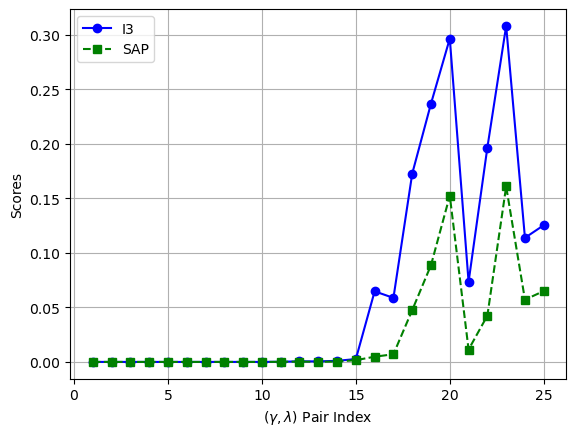

Scenario 2:


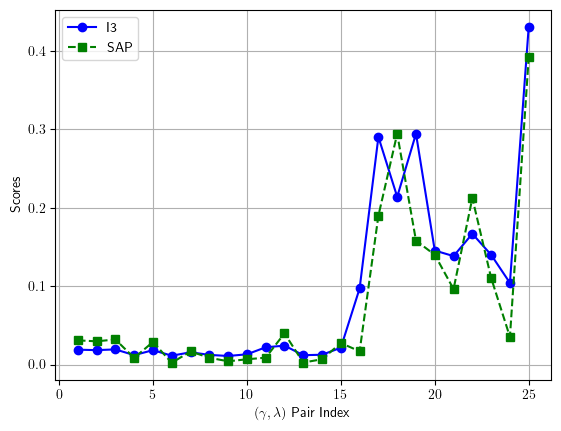

Scenario 3:


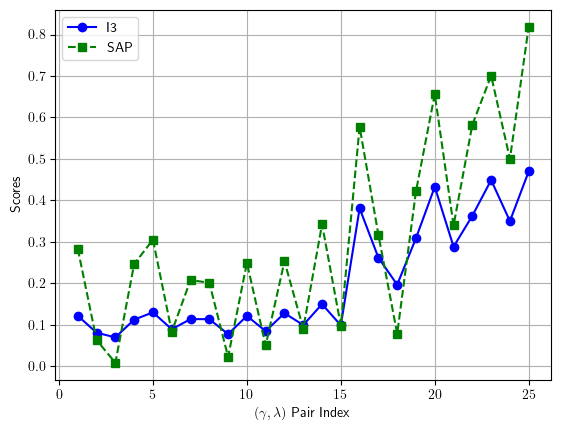

In [16]:
# Divide into three arrays, each with 25 values for each scenario
SAP_1, SAP_2, SAP_3 = np.array_split(all_SAP_score_arr, 3)
I3_1, I3_2, I3_3 = np.array_split(all_I3_score_arr, 3)

# Plot Comparison of I3 and SAP Scores for each scenario
print(colored('Scenario 1:', attrs=['bold', 'underline']))
plot_comparison(I3_1, SAP_1)

print(colored('Scenario 2:', attrs=['bold', 'underline']))
plot_comparison(I3_2, SAP_2)

print(colored('Scenario 3:', attrs=['bold', 'underline']))
plot_comparison(I3_3, SAP_3)

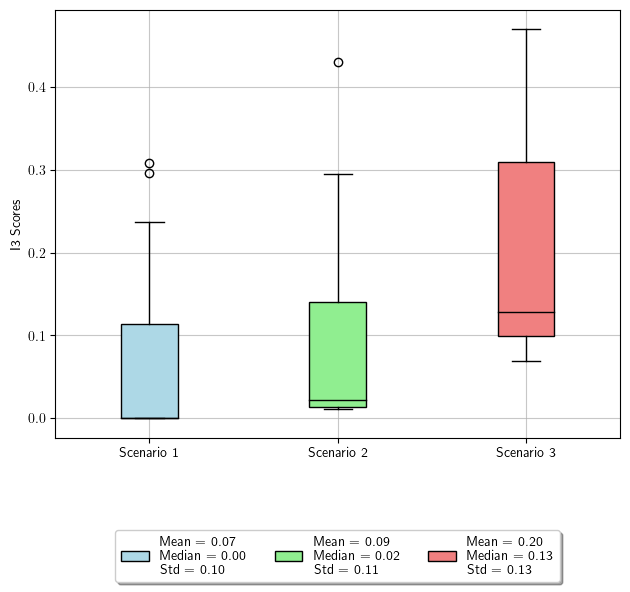

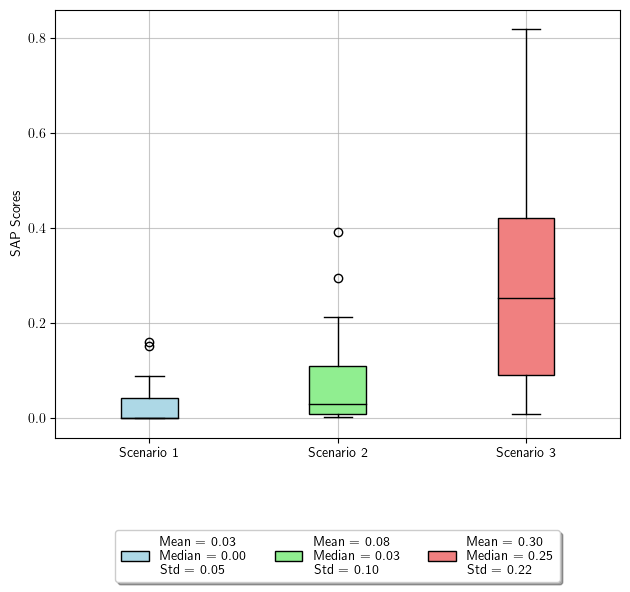

In [17]:
# Plots of Distribution of I3 and SAP Scores Across Scenarios
plot_score_across_scenarios(I3_1, I3_2, I3_3, 0)
plot_score_across_scenarios(SAP_1, SAP_2, SAP_3, 1)